# Final TCGA Model Training/Hyperparameter Opotimisation and validation against CGGA data

### Importing Libraries

In [109]:
import os

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D

import torch
import torch.nn as nn
from torch.utils.data import WeightedRandomSampler

from scipy.special import expit, logit
from scipy.stats import zscore

from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, average_precision_score,
                             roc_curve, precision_recall_curve, balanced_accuracy_score)
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.base import clone

from sksurv.metrics import cumulative_dynamic_auc
from sksurv.util import Surv

from xgboost import XGBClassifier

from skopt import BayesSearchCV
from skopt.space import Real, Integer

from skorch import NeuralNetClassifier
from skorch.callbacks import EarlyStopping, Callback

from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.pipeline import Pipeline

from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test

from statsmodels.stats.multitest import multipletests

from itertools import product

from typing import Dict, List, Tuple

from dcurves import dca, plot_graphs

### Defining ANN Helper Classes

In [110]:
#######################################
### Defining Helper Classes for ANN ###
#######################################

# Focal Loss class for enabling training focused on the difficult to predict class
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=5, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
    
    def forward(self, logits, targets):
        targets = targets.view(-1,1).type_as(logits)
        bce_loss = nn.functional.binary_cross_entropy_with_logits(logits, targets, reduction='none')
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * bce_loss
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss
        
# Class for the ANN model (binary classification)
class DeepBinary(nn.Module):
    def __init__(self, hidden_dim=64, num_layers=4, dropout_rate=0.25):
        super().__init__()
        layers = []
        layers.append(nn.LazyLinear(hidden_dim))
        layers.append(nn.LayerNorm(hidden_dim))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout_rate))

        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.LayerNorm(hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))

        layers.append(nn.Linear(hidden_dim, 1))  # final logit
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Defining NeuralNet class which will be necessary for use with skorch and skopt
class NeuralNetBinaryClassifier(NeuralNetClassifier):
    def predict_proba(self, X):
        logits = self.forward(X).detach().cpu().numpy()
        probs = expit(logits)
        return np.hstack((1 - probs, probs))

############################################
### Defining Deep Learning Skorch Set up ###
############################################

# Defining the base ANN model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = NeuralNetBinaryClassifier(
    module = DeepBinary,
    criterion = FocalLoss,
    criterion__alpha = 0.25,
    criterion__gamma = 2.0,
    max_epochs = 500,
    lr = 1e-3,
    optimizer = torch.optim.Adam,
    optimizer__weight_decay=1e-4,
    batch_size = 128,
    device = device,
    verbose = 0,
    callbacks=[
        EarlyStopping(
            monitor='valid_loss',
            threshold=0.01,
            patience=25,
            lower_is_better=True,
            load_best=True
        )
    ]
)

### Defining Hyperparameter Search Spaces

In [111]:
# Defining the ANN search space
deep_search_space = {
    "lr": Real(0.000001, 0.01, prior="log-uniform"),
    "module__hidden_dim": Integer(4, 256),
    "module__num_layers": Integer(1, 4),
    "module__dropout_rate": Real(0.0, 0.5),
    "criterion__alpha": Real(0.0, 0.5),
    "criterion__gamma": Real(1.0, 7.0)
}

############################################
### Defining non ANN model search spaces ###
############################################

search_spaces = {
    "SVM": (
        SVC(probability=True, class_weight="balanced", kernel = 'rbf', gamma='scale', random_state=42),
        {
            "C": Real(0.001, 1.0, prior="log-uniform")
        }
    ),
    "RandomForest": (
        RandomForestClassifier(class_weight="balanced", random_state=42),
        {
            "n_estimators": Integer(50, 500),
            "max_depth": Integer(2, 20),
            "min_samples_split": Integer(2, 20),
            "min_samples_leaf": Integer(1, 10),
        }
    ),
    "XGBoost": (
        XGBClassifier(eval_metric="logloss", random_state=42),
        {
            "n_estimators": Integer(50, 500),
            "max_depth": Integer(2, 20),
            "learning_rate": Real(0.001, 0.1, prior="log-uniform"),
            "subsample": Real(0.5, 1.0),
            "colsample_bytree": Real(0.5, 1.0),
            "scale_pos_weight": Real(1.0, 10.0)
        }
    ),
    "LogisticRegression": (
        LogisticRegression(max_iter=5000, class_weight="balanced", solver="lbfgs"),
        {
            "C": Real(0.001, 1.0, prior="log-uniform")
        }
    )
}

### Defining utility functions

In [112]:
##################################
### Defining Utility Functions ###
##################################

# Function to compute metrics
def compute_metrics(y_true, probs, threshold=0.5):
    y_pred = (probs >= threshold).astype(int)
    return {'accuracy': accuracy_score(y_true, y_pred),
            'precision': precision_score(y_true, y_pred, zero_division=0),
            'recall': recall_score(y_true, y_pred),
            'f1': f1_score(y_true, y_pred, zero_division=0),
            'roc_auc': roc_auc_score(y_true, probs),
            'pr_auc': average_precision_score(y_true, probs)}

# Function for tuning thresholds with Binary F1
def tune_threshold(probs, y_true):
    thresholds = np.linspace(0.25, 0.75, 101)
    best_thr, best_score = 0.5, -1.0
    for t in thresholds:
        preds = (probs >= t).astype(int)
        score = f1_score(y_true, preds,average='binary')
        if score > best_score:
            best_score, best_thr = score, t
    return best_thr, best_score

# Alternative Function for tuning on log-rank z
def tune_threshold_by_logrank(
    probs_train: np.ndarray,
    time_train: np.ndarray,
    event_train: np.ndarray,
) -> tuple[float, float]:
    
    probs_train = np.asarray(probs_train, float).ravel()
    time_train  = np.asarray(time_train,  float).ravel()
    event_train = np.asarray(event_train, bool).ravel()

    # Candidate thresholds from fixed quantiles
    qs = np.linspace(0.10, 0.70, 61)
    cands = np.unique(np.quantile(probs_train, qs))
    best_thr  = float(np.median(probs_train))
    best_stat = -np.inf
    found     = False

    for thr in cands:
        hi = probs_train >= thr
        lo = ~hi
        if hi.sum() == 0 or lo.sum() == 0:
            continue
        try:
            lr = logrank_test(
                time_train[hi], time_train[lo],
                event_observed_A=event_train[hi],
                event_observed_B=event_train[lo],
            )
            chi2 = float(lr.test_statistic)
            if np.isfinite(chi2) and chi2 > best_stat:
                best_stat = chi2
                best_thr  = float(thr)
                found     = True
        except Exception:
            continue

    if not found:
        # fallback: median threshold, 0 separation
        return float(np.median(probs_train)), 0.0

    return best_thr, best_stat

# aggregaring folds for cumulative auc plotting
def _aggregate_cd_auc(per_fold_cd: Dict[str, List[Tuple[np.ndarray, np.ndarray]]],
                      n_times_common: int = 75) -> Dict[str, dict]:
    """Interpolate per-fold cumulative_dynamic_auc onto a common grid and
    return mean/std envelopes per model.

    per_fold_cd[model] = list of (times_k, auc_k) for each outer fold.
    """
    out: Dict[str, dict] = {}

    for model, fold_list in per_fold_cd.items():
        if not fold_list:
            continue

        # Validate and normalize each (times, auc) pair
        grids: List[Tuple[np.ndarray, np.ndarray]] = []
        for times_k, auc_k in fold_list:
            t = np.asarray(times_k, dtype=float).ravel()
            a = np.asarray(auc_k, dtype=float).ravel()
            if t.ndim != 1 or a.ndim != 1 or len(t) == 0 or len(t) != len(a):
                # Skip malformed entries
                continue
            grids.append((t, a))

        if not grids:
            continue

        # Build a common time grid that lies inside *all* fold grids
        lows = [t[0] for t, _ in grids]
        highs = [t[-1] for t, _ in grids]
        t_lo = max(lows)
        t_hi = min(highs)

        if not np.isfinite(t_lo) or not np.isfinite(t_hi) or t_hi <= t_lo:
            # Fallback to median overlap
            t_lo = float(np.median(lows))
            t_hi = float(np.median(highs))
        if t_hi <= t_lo:
            # Give up on this model if no overlap exists
            continue

        common_times = np.linspace(t_lo, t_hi, n_times_common)

        # Accumulate interpolated rows in a *list*, then stack once
        auc_rows: List[np.ndarray] = []
        for t, a in grids:
            auc_rows.append(np.interp(common_times, t, a))

        if not auc_rows:
            continue
        auc_mat = np.vstack(auc_rows)

        out[model] = {
            "times_days": common_times,
            "times_years": common_times / 365.0,
            "mean": auc_mat.mean(axis=0),
            "std": auc_mat.std(axis=0),
        }

    return out

# Preparing safe time grids for cumulative auc
def make_time_grid_quantile(y_train_struct, y_test_struct, max_points: int = 40,
                            lo_q: float = 0.10, hi_q: float = 0.90) -> np.ndarray:
    ev_times = np.asarray(y_test_struct["time"][y_test_struct["event"]], dtype=float)
    if ev_times.size == 0:
        return np.array([])

    # Trim extremes on the test events and cap by train max time (required by sksurv)
    lo = np.quantile(ev_times, lo_q)
    hi = np.quantile(ev_times, hi_q)
    hi = min(hi, float(np.max(y_train_struct["time"])) - 1e-8)
    if not np.isfinite(lo) or not np.isfinite(hi) or hi <= lo:
        return np.array([])

    # Use quantiles to place points where data exist
    uniq = np.unique(ev_times[(ev_times >= lo) & (ev_times <= hi)])
    if uniq.size == 0:
        return np.array([])
    k = int(min(max_points, max(10, uniq.size)))  # 10–40 points typical
    qs = np.linspace(lo_q, hi_q, k)
    grid = np.quantile(ev_times, qs)
    return np.unique(grid)

# Filtering time grids for cumulative auc to avoid nans
def filter_auc_grid_by_comparable_pairs(y_test_struct, time_grid: np.ndarray) -> np.ndarray:
    if time_grid.size == 0:
        return time_grid
    times = np.asarray(y_test_struct["time"], dtype=float)
    events = np.asarray(y_test_struct["event"], dtype=bool)

    t_col = time_grid[:, None]    # (T,1)
    times_row = times[None, :]    # (1,N)
    events_row = events[None, :]  # (1,N)

    cases = ((events_row) & (times_row <= t_col)).sum(axis=1)  # events by t
    at_risk = (times_row >= t_col).sum(axis=1)                 # still at risk at t
    controls = at_risk - cases

    mask = (cases > 0) & (controls > 0)
    return time_grid[mask]

# Safely using sksurv
def compute_cd_auc_robust(y_train_struct, y_test_struct, risk_scores: np.ndarray,
                          base_grid: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """Return (times, auc_t) with invalid times removed. If <2 valid points, return ([], [])."""
    t_eval = filter_auc_grid_by_comparable_pairs(y_test_struct, base_grid)
    if t_eval.size < 2:
        return np.array([]), np.array([])

    auc_t, _ = cumulative_dynamic_auc(y_train_struct, y_test_struct, risk_scores, t_eval)
    auc_t = np.asarray(auc_t, dtype=float)

    # Drop any remaining non-finite values and align times
    m = np.isfinite(auc_t)
    t_eval, auc_t = t_eval[m], auc_t[m]
    if t_eval.size < 2:
        return np.array([]), np.array([])
    return t_eval, auc_t

### Defining plotting functions

### Defining training function

In [113]:
def train_evaluate_model(random_state=42,inner_folds=3,inner_iterations=25,ANN_iterations=25):

    # Stetting variables
    RANDOM_STATE = random_state
    INNER_FOLDS = inner_folds
    N_ITER_INNER = inner_iterations
    N_ITER_ANN = ANN_iterations
    N_JOBS = -1

    # Downloading TCGA Data (Training)
    TCGA_URL = "./iMAT_integrated_data/TCGA_iMAT_integrated_df_10.csv"
    TCGA = pd.read_csv(TCGA_URL).drop(columns=["sample"])
    TCGA = TCGA.dropna()
    TCGA_OS = TCGA[["OS", "OS.time"]]

    le = LabelEncoder().fit(TCGA["OS"])

    X_TCGA = TCGA.drop(columns = ["OS", "OS.time"])
    y_TCGA = le.transform(TCGA["OS"])

    # Downloading CGGA Data (Validation)
    CGGA_URL = "./CGGA_Data/CGGA_Tidied_Integrated.csv"
    CGGA = pd.read_csv(CGGA_URL).drop(columns=["CGGA_ID"])
    CGGA = CGGA.dropna()
    CGGA_OS = CGGA[["OS", "OS.time"]]

    X_CGGA = CGGA.drop(columns = ["OS", "OS.time"])
    y_CGGA = le.transform(CGGA["OS"])

    # Preparing storage dictionaries
    models_info = {name: {'estimator': m, 'space': s} for name, (m, s) in search_spaces.items()}
    models_info['ANN'] = {'estimator': net, 'space': deep_search_space}

    # Setting up event and time datasets
    TCGA_event = TCGA_OS['OS'].values.astype(bool)
    TCGA_time  = TCGA_OS['OS.time'].values.astype(float)

    CGGA_event  = CGGA_OS['OS'].values.astype(bool)
    CGGA_time   = CGGA_OS['OS.time'].values.astype(float)

    TCGA_Surv = Surv.from_arrays(event=TCGA_event, time=TCGA_time)
    CGGA_Surv  = Surv.from_arrays(event=CGGA_event, time=CGGA_time)

    fold_time_grid = make_time_grid_quantile(TCGA_Surv, CGGA_Surv, max_points=40)

    # Setting up results dataframes
    probs_train_store = {}
    probs_results = {'y_true':y_CGGA}
    class_results = {'y_true':y_CGGA}
    metrics_results = {}
    roc_results = {}
    pr_results = {}
    cd_auc_results = {}

    for model_name, info in models_info.items():
        print(f'\nTuning and Fitting: {model_name}')
        base = clone(info['estimator'])
        space = info['space']

        # Defining the pipeline for the model
        pipe = Pipeline([
            ('low_var', VarianceThreshold()),
            ('scaler', StandardScaler()),
            ('smote', SMOTE(random_state=RANDOM_STATE,sampling_strategy=0.5)),
            ('clf', base)
        ])


        # prefix search space
        space_prefixed = {f'clf__{k}': v for k, v in space.items()}

        #Selecting iterations
        n_iter = N_ITER_ANN if model_name == 'ANN' else N_ITER_INNER
        n_jobs = 1 if model_name == 'ANN' else N_JOBS

        opt=BayesSearchCV(
            estimator=pipe,
            search_spaces=space_prefixed,
            n_iter=n_iter,
            scoring='average_precision',
            cv=INNER_FOLDS,
            random_state=RANDOM_STATE,
            n_jobs=n_jobs,
            refit=True
        )

        # Fitting
        fit_X = X_TCGA.astype(np.float32) if model_name == 'ANN' else X_TCGA
        opt.fit(fit_X, y_TCGA)

        # Plotting Loss Curves
        if model_name == "ANN":
            best = opt.best_estimator_
            
            # skorch Net is inside the pipeline as step 'clf'
            net_trained = best.named_steps['clf']

            # Access the training history
            history = net_trained.history_

            # Extract values
            train_losses = history[:, 'train_loss']
            valid_losses = history[:, 'valid_loss']
            plt.figure(figsize=(6,4))
            plt.plot(train_losses, label="Train Loss")
            if valid_losses is not None:
                plt.plot(valid_losses, label="Valid Loss")
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.title(f"ANN Loss Curve")
            plt.legend()
            plt.grid(alpha=0.3)
            plt.show()
            plt.close()

        print(f"Best params for {model_name}: {opt.best_params_}")

        # In this case fit base estimator inside the pipeline without search
        pipe.set_params(**{})
        pipe.fit(fit_X, y_TCGA)
        best = opt.best_estimator_

        
        # Tuning for best threshold:
        train_preds_input = fit_X.astype(np.float32) if model_name == 'ANN' else fit_X
        probs_train = best.predict_proba(train_preds_input)[:, 1].ravel()

        # Store training probs
        probs_train_store[model_name] = probs_train

        # Tuning threshold on training data
        thr, thr_best = tune_threshold_by_logrank(probs_train=probs_train, time_train=TCGA_time,event_train=TCGA_event)
        print(f"Tuned threshold for {model_name}: {thr:.2f} (Log-Rank Chi2={thr_best:.3f})")

        # Predict proba on the test set
        test_X = X_CGGA.astype(np.float32) if model_name == 'ANN' else X_CGGA
        probs = best.predict_proba(test_X)[:, 1].ravel()

        # Preparation for cumulative dynamic plotting
        t_eval, auc_vec = compute_cd_auc_robust(TCGA_Surv, CGGA_Surv, probs, fold_time_grid)
        cd_auc_results[model_name] = (t_eval, auc_vec)

        # Storing testing probs
        probs_results[model_name] = probs
        
        # Storing out of fold predictions
        model_predictions = (probs >= thr).astype(int)
        class_results[model_name] = model_predictions

        # Compute per-fold metrics and curves
        m = compute_metrics(y_CGGA, probs, threshold=thr)
        metrics_results[model_name] = m
        fpr, tpr, _ = roc_curve(y_CGGA, probs)
        prec, rec, _ = precision_recall_curve(y_CGGA, probs)
        roc_results[model_name] = (fpr, tpr)
        pr_results[model_name] = (rec, prec)

        print(f"{model_name}: AP={m['pr_auc']:.3f}, ROC AUC={m['roc_auc']:.3f}")
    
    # Computing Ensemble predictions for this fold against the train set for threshold tuning
    L_train_cols = []
    model_list = ["SVM","RandomForest","XGBoost","LogisticRegression","ANN"]
    for m in model_list:
        p = np.clip(probs_train_store[m], 1e-6, 1-1e-6)
        L_train_cols.append(logit(p))
    L_train = np.vstack(L_train_cols).T   # columns ordered as model_list

    # Fit scaler on TRAIN, transform TRAIN
    std_scaler = StandardScaler().fit(L_train)
    Z_train = std_scaler.transform(L_train)

    probs_train_df = pd.DataFrame(Z_train, columns=[m for m in model_list])
    probs_train_df["OS"] = TCGA_event
    probs_train_df["OS.time"] = TCGA_time

    cph_train_models = CoxPHFitter(penalizer=0.05, l1_ratio=0.0)
    cph_train_models.fit(probs_train_df, duration_col = "OS.time", event_col="OS", robust=True)

    models_train_cindex = cph_train_models.concordance_index_
    print(f"\nTraining Multivariate C-Index={models_train_cindex}\n")
    
    train_summary = cph_train_models.summary.reset_index().rename(columns={'index': 'Gene'})
    train_summary_extraction = train_summary.set_index('covariate')

    cox_weights_train = {}
    weighted_probs_train = []
    for m in model_list:
        cox_weights_train[m] = train_summary_extraction.loc[m]["coef"]
        weighted_probs_train.append((probs_train_df[m]*cox_weights_train[m]))
    weighted_probs_stack_train = np.vstack(weighted_probs_train)

    ensemble_train_probs = np.sum(weighted_probs_stack_train,axis=0)
    probs_min_scaler = MinMaxScaler()
    ensemble_train_probs = probs_min_scaler.fit_transform(ensemble_train_probs.reshape(-1,1)).flatten()

    # Tuning Ensemble threshold on ensemble_train_probs
    thr_ens, thr_ens_best = tune_threshold_by_logrank(probs_train=ensemble_train_probs, time_train=TCGA_time,event_train=TCGA_event)
    probs_train_store['Ensemble'] = ensemble_train_probs
    print(f"Tuned threshold for Ensemble: {thr_ens:.2f} (Log-Rank Chi2={thr_ens_best:.3f})")

    # Computing Ensemble predictions for this fold against the test set
    L_test_cols = []
    for m in model_list:
        p = np.clip(probs_results[m], 1e-6, 1-1e-6)
        L_test_cols.append(logit(p))
    L_test = np.vstack(L_test_cols).T
    
    Z_test = std_scaler.transform(L_test)

    probs_test_df = pd.DataFrame(Z_test, columns=[m for m in model_list])
    probs_test_df["OS"] = CGGA_event
    probs_test_df["OS.time"] = CGGA_time

    weighted_probs_test = []
    for m in model_list:
        weighted_probs_test.append((probs_test_df[m]*cox_weights_train[m]))
    weighted_probs_stack_test = np.vstack(weighted_probs_test)

    ensemble_test_probs = np.sum(weighted_probs_stack_test,axis=0)
    ensemble_test_probs = probs_min_scaler.transform(ensemble_test_probs.reshape(-1,1)).flatten()
    probs_results['Ensemble'] = ensemble_test_probs

    t_eval, auc_vec = compute_cd_auc_robust(TCGA_Surv, CGGA_Surv, ensemble_test_probs, fold_time_grid)
    cd_auc_results['Ensemble'] = (t_eval, auc_vec)

    #Calculating ensemble predictions
    ensemble_preds = (ensemble_test_probs >= thr_ens).astype(int)
    class_results['Ensemble'] = ensemble_preds

    # Store ensemble metrics and curves
    m_ens = compute_metrics(y_CGGA, ensemble_test_probs, threshold=thr_ens)
    metrics_results['Ensemble'] = (m_ens)
    fpr, tpr, _ = roc_curve(y_CGGA, ensemble_test_probs)
    prec, rec, _ = precision_recall_curve(y_CGGA, ensemble_test_probs)
    roc_results['Ensemble'] = (fpr, tpr)
    pr_results['Ensemble'] = (rec, prec)
    
    probs_df = pd.DataFrame(probs_results)
    class_df = pd.DataFrame(class_results)

    model_list = ["SVM","RandomForest","XGBoost","LogisticRegression","ANN","Ensemble"]

    summary_df = pd.DataFrame({
        'y_true': y_CGGA,
        'OS.time': CGGA_time,
        'OS': CGGA_event.astype(int)
    })

    for m in model_list:
        summary_df[f'prob_{m}'] = probs_results[m]
        summary_df[f'pred_{m}'] = class_results[m]

    # metrics_summary = {}
    # for m in model_list + ['Ensemble']:
    #     vals = metrics_results[m]
    #     summary = {k: (np.mean([v[k] for v in vals]), np.std([v[k] for v in vals])) for k in vals[0].keys()}
    #     metrics_summary[m] = summary
    
    curves_summary = {'roc': {}, 'pr': {}}
    all_models_for_plot = model_list + ['Ensemble']
    for m in all_models_for_plot:
        fpr, tpr, _ = roc_curve(probs_df['y_true'], probs_df[m])
        prec, rec, _ = precision_recall_curve(probs_df['y_true'], probs_df[m])
        curves_summary['roc'][m] = fpr, tpr
        curves_summary['pr'][m]  = rec, prec

    # # Prepare metrics dictionary
    metrics_for_plot = metrics_results

    # Preparing survival resutls dictionaries
    survival_results = {}
    for m in all_models_for_plot:
        p = np.clip(probs_df[m].values, 1e-6, 1-1e-6)
        logit_p = logit(p)
        logit_scaled = zscore(logit_p)

        survival_results[m] = [(probs_test_df[['OS.time', 'OS']], 
                                {"class": class_df[m].values.astype(int),
                                 "logit_scaled": logit_scaled})]
    
    # Preparing results for cumulative auc
    # cauc_agg = _aggregate_cd_auc(cd_auc_results, n_times_common=50)

    return summary_df, curves_summary, metrics_for_plot, survival_results, y_CGGA, # cauc_agg


Tuning and Fitting: SVM
Best params for SVM: OrderedDict([('clf__C', 0.3261371331798659)])
Tuned threshold for SVM: 0.37 (Log-Rank Chi2=147.780)
SVM: AP=0.642, ROC AUC=0.639

Tuning and Fitting: RandomForest
Best params for RandomForest: OrderedDict([('clf__max_depth', 2), ('clf__min_samples_leaf', 10), ('clf__min_samples_split', 20), ('clf__n_estimators', 422)])
Tuned threshold for RandomForest: 0.49 (Log-Rank Chi2=93.210)
RandomForest: AP=0.664, ROC AUC=0.654

Tuning and Fitting: XGBoost
Best params for XGBoost: OrderedDict([('clf__colsample_bytree', 0.9536968185484578), ('clf__learning_rate', 0.001), ('clf__max_depth', 2), ('clf__n_estimators', 62), ('clf__scale_pos_weight', 1.0), ('clf__subsample', 0.5)])
Tuned threshold for XGBoost: 0.33 (Log-Rank Chi2=85.765)
XGBoost: AP=0.640, ROC AUC=0.629

Tuning and Fitting: LogisticRegression
Best params for LogisticRegression: OrderedDict([('clf__C', 0.017107681288783472)])
Tuned threshold for LogisticRegression: 0.53 (Log-Rank Chi2=99.072

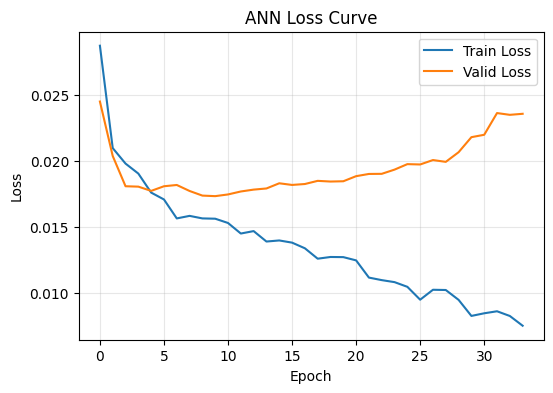

Best params for ANN: OrderedDict([('clf__criterion__alpha', 0.15681838000393858), ('clf__criterion__gamma', 2.4223027215318185), ('clf__lr', 0.0002946785449104751), ('clf__module__dropout_rate', 0.18182422574382015), ('clf__module__hidden_dim', 256), ('clf__module__num_layers', 4)])
Tuned threshold for ANN: 0.46 (Log-Rank Chi2=121.456)
ANN: AP=0.671, ROC AUC=0.668

Training Multivariate C-Index=0.8457719900717419

Tuned threshold for Ensemble: 0.45 (Log-Rank Chi2=132.250)


In [ ]:
summary_df, curves_summary, metrics_for_plot, survival_results, y_CGGA= train_evaluate_model(random_state=1,inner_folds=5,inner_iterations=100,ANN_iterations=100)

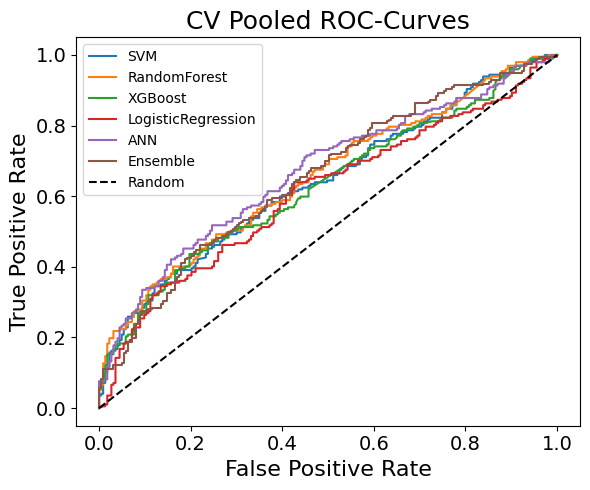

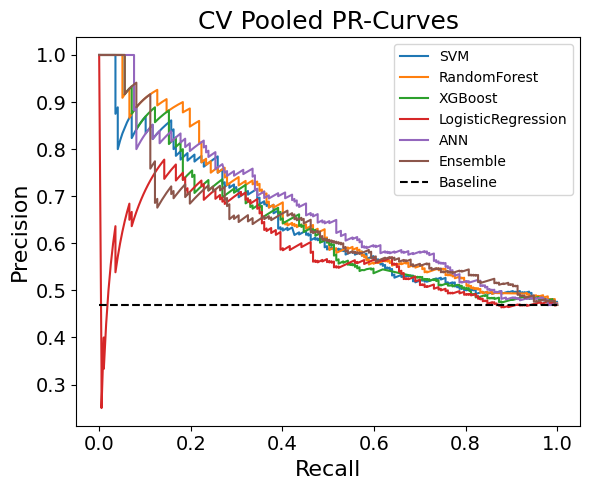

In [115]:
# Function to plot mean ROC curves
def plot_mean_roc(curves_summary):
    plt.figure(figsize=(6,5))
    for model_name, (fpr, mean_tpr) in curves_summary['roc'].items():
        plt.plot(fpr, mean_tpr, label=f'{model_name}')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title("CV Pooled ROC-Curves", fontsize=18)
    plt.tick_params(axis="both", labelsize=14)
    plt.legend()
    plt.tight_layout()
    plt.show()
    plt.close()

# Function to plot mean PR curves
def plot_mean_pr(curves_summary):
    plt.figure(figsize=(6,5))
    for model_name, (recall, mean_prec) in curves_summary['pr'].items():
        plt.plot(recall, mean_prec, label=f'{model_name}')
    plt.hlines(y_CGGA.sum()/len(y_CGGA), 0, 1, colors="k", linestyles="--", label="Baseline")
    plt.xlabel('Recall', fontsize=16)
    plt.ylabel('Precision', fontsize=16)
    plt.title("CV Pooled PR-Curves", fontsize=18)
    plt.tick_params(axis="both", labelsize=14)
    plt.legend()
    plt.tight_layout()
    plt.show()
    plt.close()

plot_mean_roc(curves_summary)
plot_mean_pr(curves_summary)

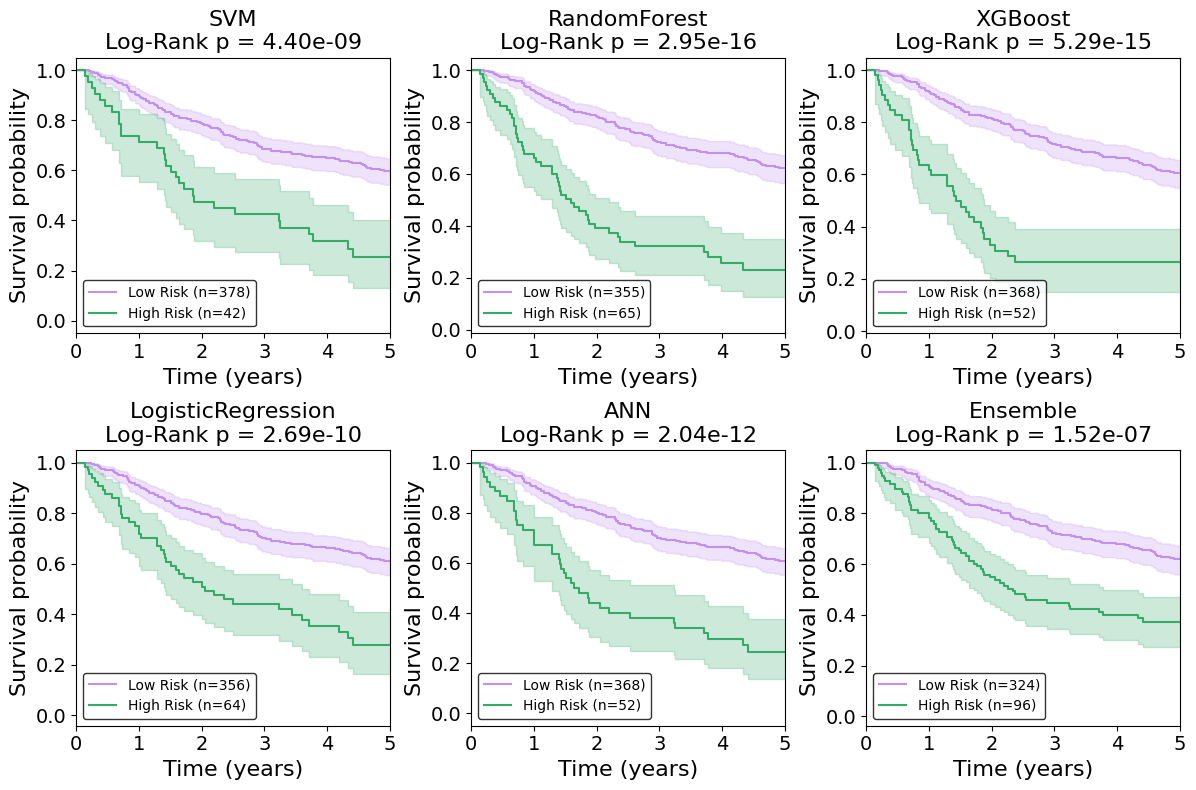

In [116]:
def plot_km_curves(survival_results, max_years=5):
    risk_labels = {0: "Low Risk", 1: "High Risk"}
    model_list = list(survival_results.keys())
    colours = ["#C190F0", "#35AB6A"]

    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    axes = axes.flatten()
    logrank_ps = []
    iteration = 0
    for idx, model_name in enumerate(model_list):
        ax = axes[idx]

        # Pool all folds
        dfs = []
        for OS_val, pred_dict in survival_results[model_name]:
            temp = OS_val.copy()
            temp["pred_class"] = pred_dict["class"]
            dfs.append(temp)
        pooled_df = pd.concat(dfs, ignore_index=True).dropna()

        high = pooled_df[pooled_df["pred_class"] == 1]
        low  = pooled_df[pooled_df["pred_class"] == 0]
        lr_res = logrank_test(
            high["OS.time"], low["OS.time"],
            event_observed_A=high["OS"], event_observed_B=low["OS"]
        )
        p_val = lr_res.p_value
        logrank_ps.append(p_val)
        ax.set_title(f"{model_name}\nLog-Rank p = {logrank_ps[iteration]:.2e}", fontsize=16)
        iteration += 1
        # KM curves
        kmf = KaplanMeierFitter()
        for cls in [0, 1]:
            mask = pooled_df["pred_class"] == cls
            n_value = mask.sum()
            kmf.fit(
                durations=pooled_df.loc[mask, "OS.time"] / 365,
                event_observed=pooled_df.loc[mask, "OS"],
                label=f"{risk_labels[cls]} (n={n_value})"
            )
            kmf.plot_survival_function(ax=ax, ci_show=True, color=colours[cls])

        ax.set_xlim(0, max_years)
        ax.set_xlabel("Time (years)", fontsize=16)
        ax.set_ylabel("Survival probability", fontsize=16)
        ax.tick_params(axis="both", labelsize=14)
        ax.legend(fontsize=10,loc="lower left",edgecolor="black")

    # Remove unused subplots
    for j in range(idx + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()
    plt.close()

plot_km_curves(survival_results,max_years=5)